## importing necessary modules

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pickle


In [17]:
# Load the dataset
file_path = "HousePricePrediction.xlsx"
dataset = pd.read_excel(file_path)

In [18]:
print(dataset.shape)

(2919, 13)


In [19]:
# Print the first 5 rows and shape of the dataset
print("First 5 rows of the dataset:")
print(dataset.head(5))

First 5 rows of the dataset:
   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


## Data Preprocessing


In [20]:
# Categorize features by data type
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("\nCategorical variables:", len(object_cols))

int_ = (dataset.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (dataset.dtypes == 'float64')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))


Categorical variables: 4
Integer variables: 6
Float variables: 3


##  Exploratory Data Analysis

### Correlation Heatmap


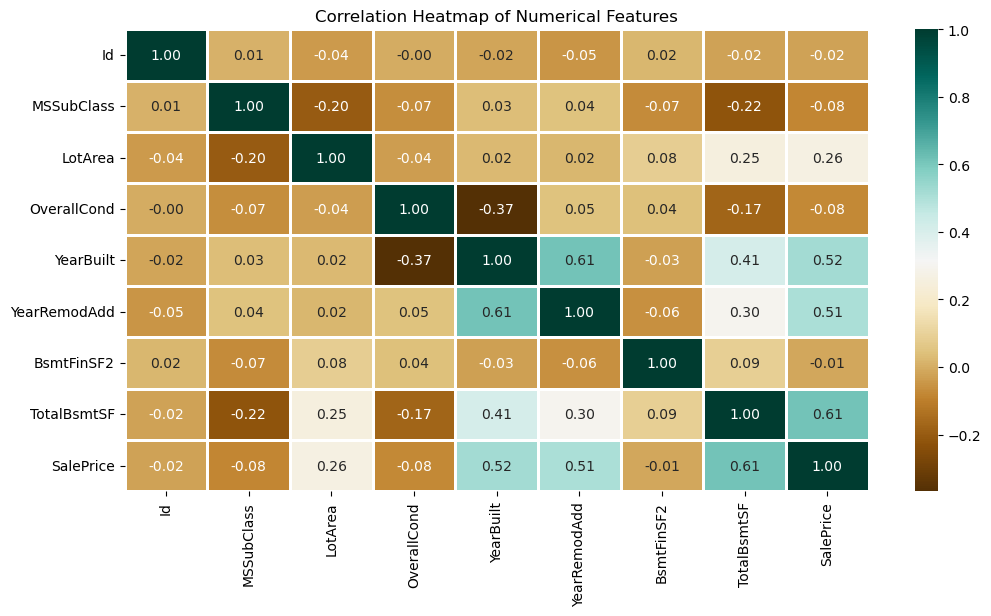

In [21]:
numerical_dataset = dataset.select_dtypes(include=['number'])
plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap='BrBG',
            fmt='.2f',
            linewidths=2,
            annot=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Bar plot of Unique Categorical Values

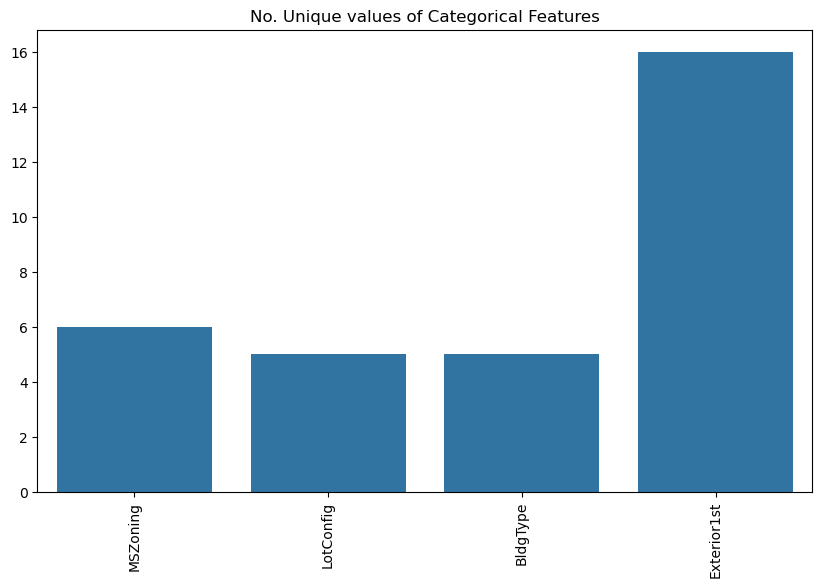

In [22]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols, y=unique_values)
plt.show()

### Distribution of Categorical Features

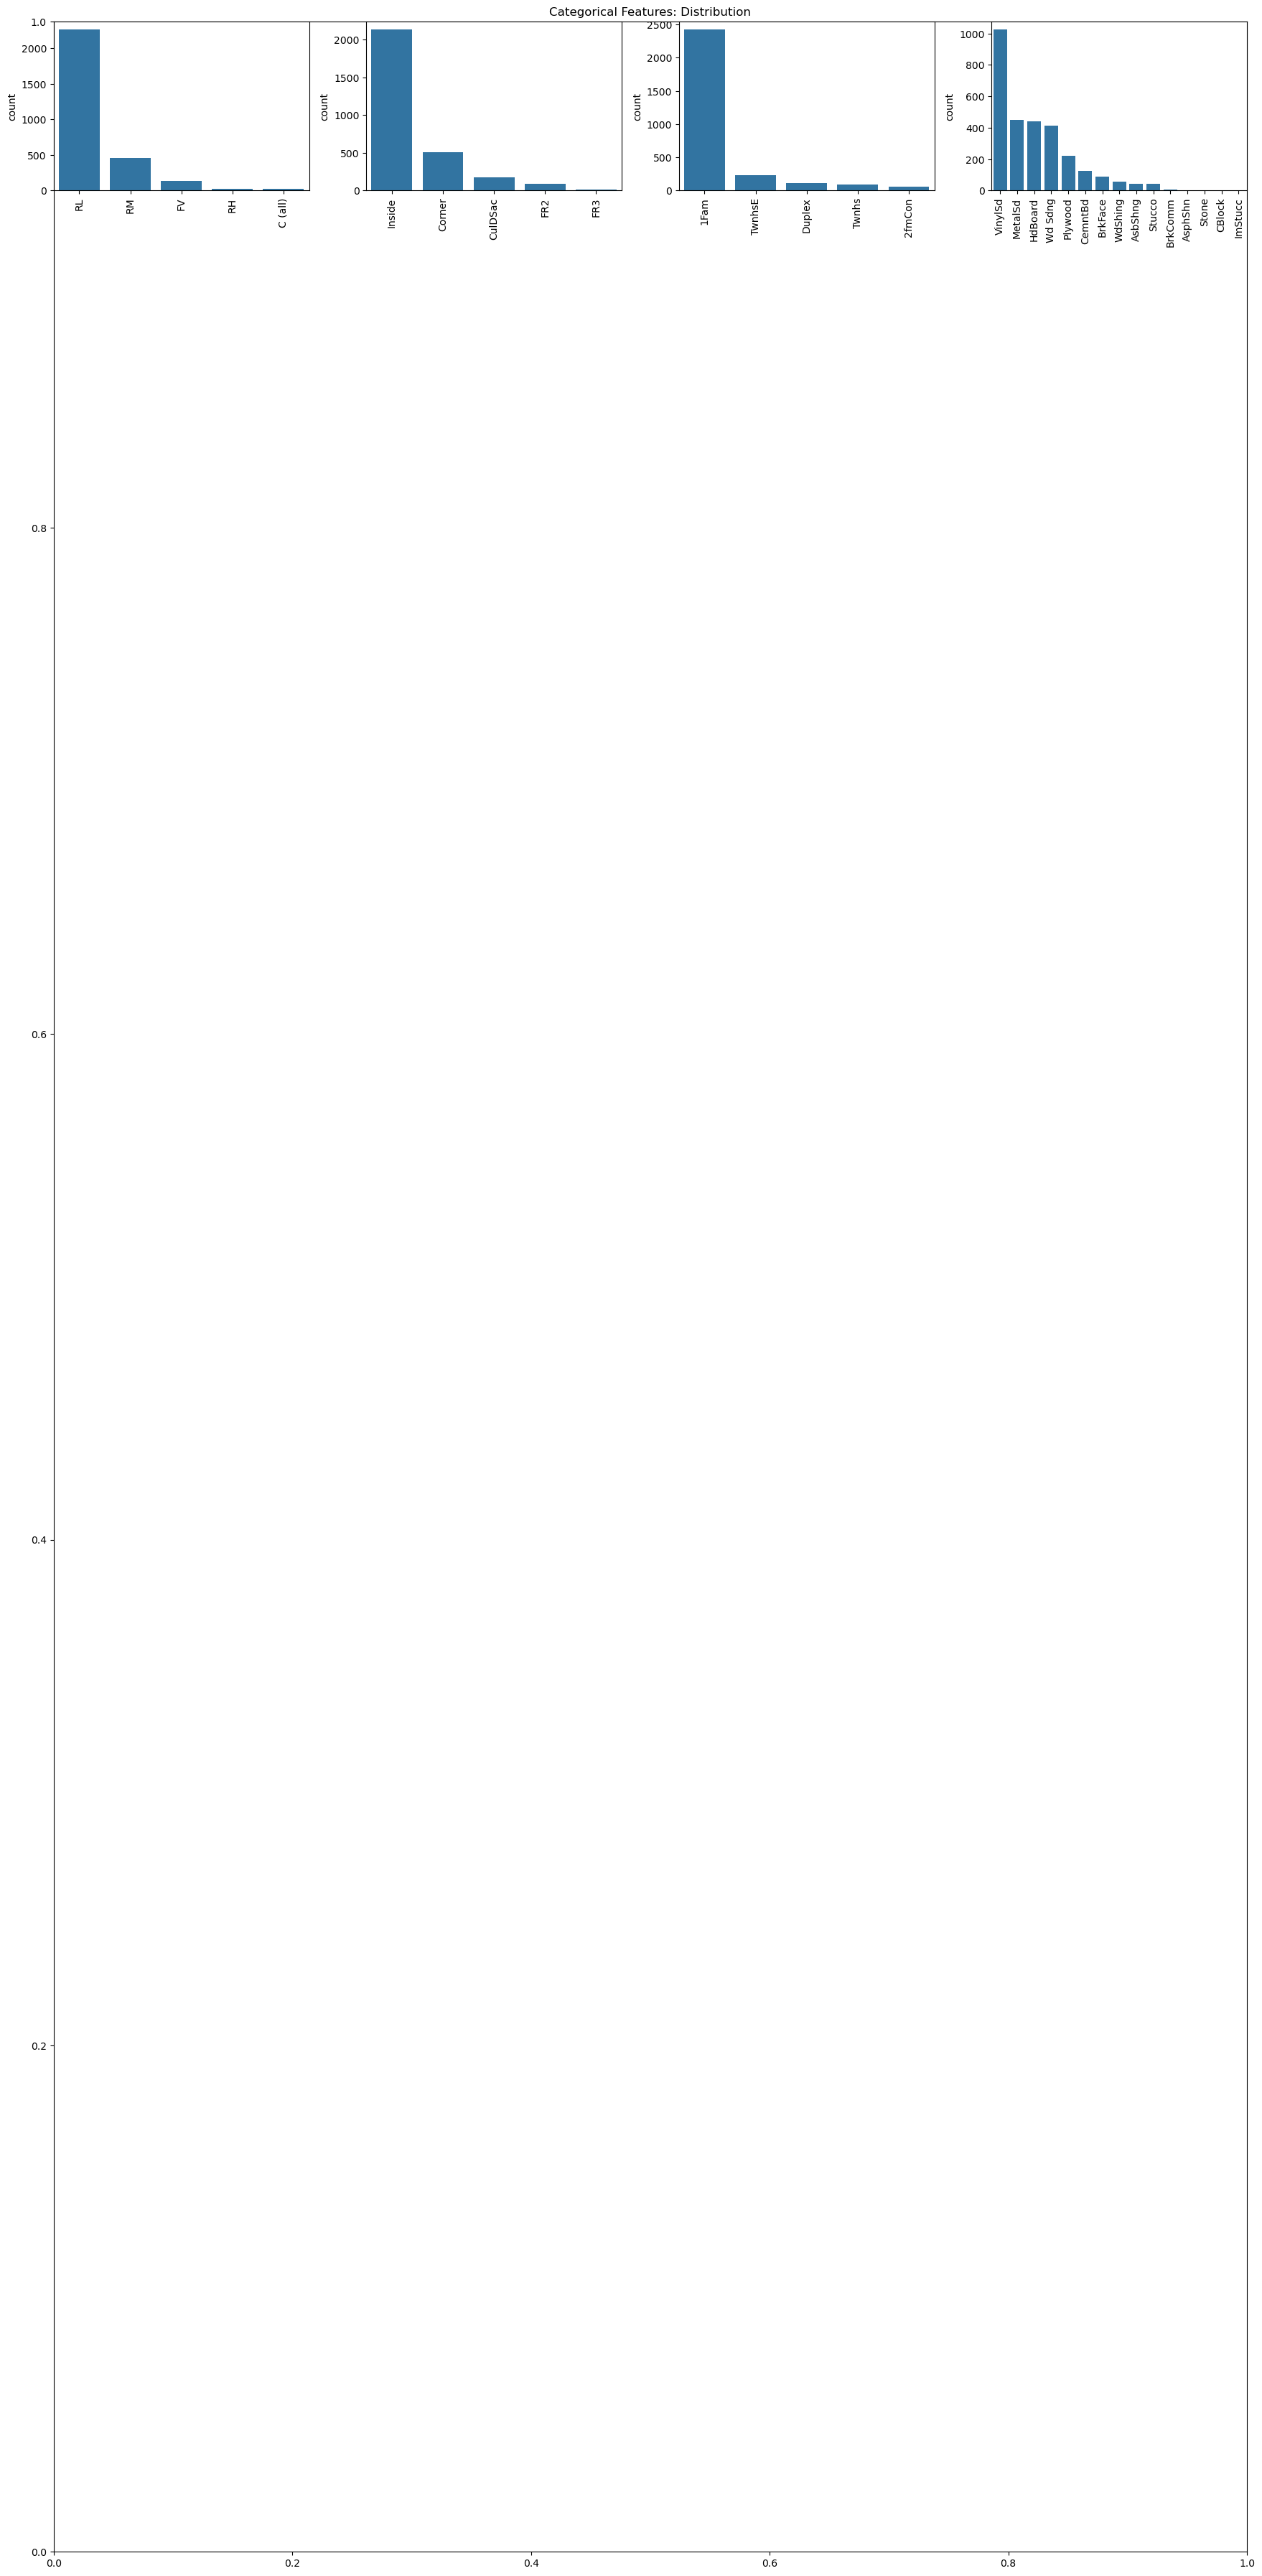

In [23]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
index = 1
for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1
plt.tight_layout()
plt.show()

## Data Cleaning

In [24]:
print(new_dataset.isnull().sum())

MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64


In [25]:
#drop 'Id' column as it's not useful for prediction
dataset.drop(['Id'], axis=1, inplace=True)

# Fill missing 'SalePrice' values with the mean
dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

In [26]:
# Drop rows with any remaining null values
new_dataset = dataset.dropna()

# Check for any remaining null values
print("Null values in new dataset:")
print(new_dataset.isnull().sum())

Null values in new dataset:
MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64


##  OneHotEncoder

In [27]:
s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables after cleaning:")
print(object_cols)
print('No. of. categorical features: ', len(object_cols))

Categorical variables after cleaning:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [28]:
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()

In [29]:
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

print("\nFirst 5 rows of the final dataset after OneHotEncoding:")
df_final.head()



First 5 rows of the final dataset after OneHotEncoding:


,MSSubClass,LotArea,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice,MSZoning_C (all),MSZoning_FV,...,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing
0,60,8450,5,2003,2003,0.0,856.0,208500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20,9600,8,1976,1976,0.0,1262.0,181500.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60,11250,5,2001,2002,0.0,920.0,223500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,70,9550,5,1915,1970,0.0,756.0,140000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,60,14260,5,2000,2000,0.0,1145.0,250000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
print("\nShape of the final dataset:")
print(df_final.shape)


Shape of the final dataset:
(2913, 38)


## Splitting Dataset

In [31]:
X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_valid:", Y_valid.shape)


Shape of X_train: (2330, 37)
Shape of X_valid: (583, 37)
Shape of Y_train: (2330,)
Shape of Y_valid: (583,)


## Model Training and Accuracy

In [32]:
#SVM - Support Vector Machine
model_SVR = SVR()
model_SVR.fit(X_train, Y_train)
Y_pred_SVR = model_SVR.predict(X_valid)
mape_SVR = mean_absolute_percentage_error(Y_valid, Y_pred_SVR)
print(f"Mean Absolute Percentage Error (SVR): {mape_SVR}\n")

Mean Absolute Percentage Error (SVR): 0.1870512931870423



In [33]:
#Random Forest Regression
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred_RFR = model_RFR.predict(X_valid)
mape_RFR = mean_absolute_percentage_error(Y_valid, Y_pred_RFR)
print(f"Mean Absolute Percentage Error (Random Forest): {mape_RFR}\n")

Mean Absolute Percentage Error (Random Forest): 0.18999225260631736



In [34]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred_LR = model_LR.predict(X_valid)
mape_LR = mean_absolute_percentage_error(Y_valid, Y_pred_LR)
print(f"Mean Absolute Percentage Error (Linear Regression): {mape_LR}")

Mean Absolute Percentage Error (Linear Regression): 0.18741683841599951


In [35]:
#Pickling the Best Model
models = {
    'SVR': mape_SVR,
    'RandomForestRegressor': mape_RFR,
    'LinearRegression': mape_LR
}
best_model_name = min(models, key=models.get)
print(f"The best model is: {best_model_name} with MAPE of {models[best_model_name]}")

if best_model_name == 'SVR':
    best_model = model_SVR
elif best_model_name == 'RandomForestRegressor':
    best_model = model_RFR
else:
    best_model = model_LR

with open('house_price_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Best model has been pickled successfully to 'house_price_model.pkl'!")

The best model is: SVR with MAPE of 0.1870512931870423
Best model has been pickled successfully to 'house_price_model.pkl'!


In [36]:
#Prediction
import pandas as pd
import pickle
import numpy as np

# Load the pickled model
with open('house_price_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Create a new data point for prediction
# This new data point MUST have the same features as the training data,
# including the one-hot encoded columns.
# We will create a sample house with specific characteristics.

# Define the features for the new house.
# All one-hot encoded columns must be present with a value of 0 or 1.
# The order of the columns is important and must match the training data.
new_house_features = pd.DataFrame({
    'MSSubClass': [20],
    'LotArea': [800],
    'OverallCond': [7],
    'YearBuilt': [1999],
    'YearRemodAdd': [2006],
    'BsmtFinSF2': [0.0],
    'TotalBsmtSF': [1000.0],
    'MSZoning_C (all)': [0.0],
    'MSZoning_FV': [0.0],
    'MSZoning_RH': [0.0],
    'MSZoning_RL': [1.0],  # Residential Low Density
    'MSZoning_RM': [0.0],
    'LotConfig_Corner': [0.0],
    'LotConfig_CulDSac': [0.0],
    'LotConfig_FR2': [0.0],
    'LotConfig_FR3': [0.0],
    'LotConfig_Inside': [1.0],  # Inside lot
    'BldgType_1Fam': [1.0],  # Single-family Detached
    'BldgType_2fmCon': [0.0],
    'BldgType_Duplex': [0.0],
    'BldgType_Twnhs': [0.0],
    'BldgType_TwnhsE': [0.0],
    'Exterior1st_AsbShng': [0.0],
    'Exterior1st_AsphShn': [0.0],
    'Exterior1st_BrkComm': [0.0],
    'Exterior1st_BrkFace': [0.0],
    'Exterior1st_CBlock': [0.0],
    'Exterior1st_CemntBd': [0.0],
    'Exterior1st_HdBoard': [0.0],
    'Exterior1st_ImStucc': [0.0],
    'Exterior1st_MetalSd': [0.0],
    'Exterior1st_Plywood': [0.0],
    'Exterior1st_Stone': [0.0],
    'Exterior1st_Stucco': [0.0],
    'Exterior1st_VinylSd': [1.0],  # Vinyl Siding
    'Exterior1st_Wd Sdng': [0.0],
    'Exterior1st_WdShing': [0.0]
})

# Make a prediction using the loaded model
predicted_price = loaded_model.predict(new_house_features)

print(f"The predicted house price is: ${predicted_price[0]:,.2f}")

The predicted house price is: $180,921.16


In [37]:
import pandas as pd
import pickle

# Load the pickled model
with open('house_price_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Create a data point for a "low-value" house with significantly different features
low_value_house = pd.DataFrame({
    'MSSubClass': [20],
    'LotArea': [5000],
    'OverallCond': [3],
    'YearBuilt': [1950],
    'YearRemodAdd': [1950],
    'BsmtFinSF2': [0.0],
    'TotalBsmtSF': [500.0],
    'MSZoning_C (all)': [0.0],
    'MSZoning_FV': [0.0],
    'MSZoning_RH': [0.0],
    'MSZoning_RL': [1.0],
    'MSZoning_RM': [0.0],
    'LotConfig_Corner': [0.0],
    'LotConfig_CulDSac': [0.0],
    'LotConfig_FR2': [0.0],
    'LotConfig_FR3': [0.0],
    'LotConfig_Inside': [1.0],
    'BldgType_1Fam': [1.0],
    'BldgType_2fmCon': [0.0],
    'BldgType_Duplex': [0.0],
    'BldgType_Twnhs': [0.0],
    'BldgType_TwnhsE': [0.0],
    'Exterior1st_AsbShng': [0.0],
    'Exterior1st_AsphShn': [0.0],
    'Exterior1st_BrkComm': [0.0],
    'Exterior1st_BrkFace': [0.0],
    'Exterior1st_CBlock': [0.0],
    'Exterior1st_CemntBd': [0.0],
    'Exterior1st_HdBoard': [0.0],
    'Exterior1st_ImStucc': [0.0],
    'Exterior1st_MetalSd': [0.0],
    'Exterior1st_Plywood': [0.0],
    'Exterior1st_Stone': [0.0],
    'Exterior1st_Stucco': [0.0],
    'Exterior1st_VinylSd': [1.0],
    'Exterior1st_Wd Sdng': [0.0],
    'Exterior1st_WdShing': [0.0]
})

# Create a data point for a "high-value" house
high_value_house = pd.DataFrame({
    'MSSubClass': [60],
    'LotArea': [15000],
    'OverallCond': [8],
    'YearBuilt': [2020],
    'YearRemodAdd': [2020],
    'BsmtFinSF2': [0.0],
    'TotalBsmtSF': [1500.0],
    'MSZoning_C (all)': [0.0],
    'MSZoning_FV': [0.0],
    'MSZoning_RH': [0.0],
    'MSZoning_RL': [1.0],
    'MSZoning_RM': [0.0],
    'LotConfig_Corner': [0.0],
    'LotConfig_CulDSac': [0.0],
    'LotConfig_FR2': [0.0],
    'LotConfig_FR3': [0.0],
    'LotConfig_Inside': [1.0],
    'BldgType_1Fam': [1.0],
    'BldgType_2fmCon': [0.0],
    'BldgType_Duplex': [0.0],
    'BldgType_Twnhs': [0.0],
    'BldgType_TwnhsE': [0.0],
    'Exterior1st_AsbShng': [0.0],
    'Exterior1st_AsphShn': [0.0],
    'Exterior1st_BrkComm': [0.0],
    'Exterior1st_BrkFace': [0.0],
    'Exterior1st_CBlock': [0.0],
    'Exterior1st_CemntBd': [0.0],
    'Exterior1st_HdBoard': [0.0],
    'Exterior1st_ImStucc': [0.0],
    'Exterior1st_MetalSd': [0.0],
    'Exterior1st_Plywood': [0.0],
    'Exterior1st_Stone': [0.0],
    'Exterior1st_Stucco': [0.0],
    'Exterior1st_VinylSd': [1.0],
    'Exterior1st_Wd Sdng': [0.0],
    'Exterior1st_WdShing': [0.0]
})

# Make predictions for both houses
predicted_price_low = loaded_model.predict(low_value_house)
predicted_price_high = loaded_model.predict(high_value_house)

print(f"Predicted price for the 'low-value' house: ${predicted_price_low[0]:,.2f}")
print(f"Predicted price for the 'high-value' house: ${predicted_price_high[0]:,.2f}")

Predicted price for the 'low-value' house: $180,921.02
Predicted price for the 'high-value' house: $180,921.30


In [38]:
# Pickle the newly trained model
with open('house_price_model.pkl', 'wb') as f:
    pickle.dump(model_LR, f)


In [39]:
import pandas as pd
import pickle

# Load the pickled model
with open('house_price_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Create a data point for a "low-value" house with significantly different features
low_value_house = pd.DataFrame({
    'MSSubClass': [20],
    'LotArea': [5000],
    'OverallCond': [3],
    'YearBuilt': [1950],
    'YearRemodAdd': [1950],
    'BsmtFinSF2': [0.0],
    'TotalBsmtSF': [500.0],
    'MSZoning_C (all)': [0.0],
    'MSZoning_FV': [0.0],
    'MSZoning_RH': [0.0],
    'MSZoning_RL': [1.0],
    'MSZoning_RM': [0.0],
    'LotConfig_Corner': [0.0],
    'LotConfig_CulDSac': [0.0],
    'LotConfig_FR2': [0.0],
    'LotConfig_FR3': [0.0],
    'LotConfig_Inside': [1.0],
    'BldgType_1Fam': [1.0],
    'BldgType_2fmCon': [0.0],
    'BldgType_Duplex': [0.0],
    'BldgType_Twnhs': [0.0],
    'BldgType_TwnhsE': [0.0],
    'Exterior1st_AsbShng': [0.0],
    'Exterior1st_AsphShn': [0.0],
    'Exterior1st_BrkComm': [0.0],
    'Exterior1st_BrkFace': [0.0],
    'Exterior1st_CBlock': [0.0],
    'Exterior1st_CemntBd': [0.0],
    'Exterior1st_HdBoard': [0.0],
    'Exterior1st_ImStucc': [0.0],
    'Exterior1st_MetalSd': [0.0],
    'Exterior1st_Plywood': [0.0],
    'Exterior1st_Stone': [0.0],
    'Exterior1st_Stucco': [0.0],
    'Exterior1st_VinylSd': [1.0],
    'Exterior1st_Wd Sdng': [0.0],
    'Exterior1st_WdShing': [0.0]
})

# Create a data point for a "high-value" house
high_value_house = pd.DataFrame({
    'MSSubClass': [60],
    'LotArea': [15000],
    'OverallCond': [8],
    'YearBuilt': [2020],
    'YearRemodAdd': [2020],
    'BsmtFinSF2': [0.0],
    'TotalBsmtSF': [1500.0],
    'MSZoning_C (all)': [0.0],
    'MSZoning_FV': [0.0],
    'MSZoning_RH': [0.0],
    'MSZoning_RL': [1.0],
    'MSZoning_RM': [0.0],
    'LotConfig_Corner': [0.0],
    'LotConfig_CulDSac': [0.0],
    'LotConfig_FR2': [0.0],
    'LotConfig_FR3': [0.0],
    'LotConfig_Inside': [1.0],
    'BldgType_1Fam': [1.0],
    'BldgType_2fmCon': [0.0],
    'BldgType_Duplex': [0.0],
    'BldgType_Twnhs': [0.0],
    'BldgType_TwnhsE': [0.0],
    'Exterior1st_AsbShng': [0.0],
    'Exterior1st_AsphShn': [0.0],
    'Exterior1st_BrkComm': [0.0],
    'Exterior1st_BrkFace': [0.0],
    'Exterior1st_CBlock': [0.0],
    'Exterior1st_CemntBd': [0.0],
    'Exterior1st_HdBoard': [0.0],
    'Exterior1st_ImStucc': [0.0],
    'Exterior1st_MetalSd': [0.0],
    'Exterior1st_Plywood': [0.0],
    'Exterior1st_Stone': [0.0],
    'Exterior1st_Stucco': [0.0],
    'Exterior1st_VinylSd': [1.0],
    'Exterior1st_Wd Sdng': [0.0],
    'Exterior1st_WdShing': [0.0]
})

# Make predictions for both houses
predicted_price_low = loaded_model.predict(low_value_house)
predicted_price_high = loaded_model.predict(high_value_house)

print(f"Predicted price for the 'low-value' house: ${predicted_price_low[0]:,.2f}")
print(f"Predicted price for the 'high-value' house: ${predicted_price_high[0]:,.2f}")

Predicted price for the 'low-value' house: $117,817.38
Predicted price for the 'high-value' house: $251,565.48
